In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512) 
        self.fc0 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [129]:
#torch.manual_seed(7)

In [130]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67757/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67757/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [131]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67757/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67757/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [132]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [133]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []
tacc=[]

l2_lambda = 0.00001

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 

        l2_penalty = sum(torch.sum(p**2) for p in model.parameters())
        loss += l2_lambda * l2_penalty 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()

    tacc.append(tcorr/ttot)
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 128.64it/s]


Epoch 0/100, Loss: 0.01808919385075569, train dataset accuracy: 78.60166666666667
test dataset accuracy: 94.56%


100%|██████████| 235/235 [00:01<00:00, 174.15it/s]


Epoch 1/100, Loss: 0.010621798224747181, train dataset accuracy: 95.41
test dataset accuracy: 95.67%


100%|██████████| 235/235 [00:01<00:00, 176.63it/s]


Epoch 2/100, Loss: 0.00923972949385643, train dataset accuracy: 95.99166666666666
test dataset accuracy: 96.04%


100%|██████████| 235/235 [00:01<00:00, 180.10it/s]


Epoch 3/100, Loss: 0.01890595629811287, train dataset accuracy: 96.17
test dataset accuracy: 96.16%


100%|██████████| 235/235 [00:01<00:00, 181.61it/s]


Epoch 4/100, Loss: 0.015980800613760948, train dataset accuracy: 96.34666666666666
test dataset accuracy: 96.02%


100%|██████████| 235/235 [00:01<00:00, 165.42it/s]


Epoch 5/100, Loss: 0.01150570623576641, train dataset accuracy: 96.42
test dataset accuracy: 96.15%


100%|██████████| 235/235 [00:01<00:00, 183.00it/s]


Epoch 6/100, Loss: 0.0073578450828790665, train dataset accuracy: 96.365
test dataset accuracy: 96.09%


100%|██████████| 235/235 [00:01<00:00, 170.56it/s]


Epoch 7/100, Loss: 0.008758257143199444, train dataset accuracy: 96.40666666666667
test dataset accuracy: 96.28%


100%|██████████| 235/235 [00:01<00:00, 174.82it/s]


Epoch 8/100, Loss: 0.016857482492923737, train dataset accuracy: 96.475
test dataset accuracy: 96.31%


100%|██████████| 235/235 [00:01<00:00, 169.42it/s]


Epoch 9/100, Loss: 0.008181204088032246, train dataset accuracy: 96.45
test dataset accuracy: 95.85%


100%|██████████| 235/235 [00:01<00:00, 178.09it/s]


Epoch 10/100, Loss: 0.0069832345470786095, train dataset accuracy: 96.335
test dataset accuracy: 96.5%


100%|██████████| 235/235 [00:01<00:00, 179.02it/s]


Epoch 11/100, Loss: 0.014686224982142448, train dataset accuracy: 96.58166666666666
test dataset accuracy: 96.25%


100%|██████████| 235/235 [00:01<00:00, 176.51it/s]


Epoch 12/100, Loss: 0.011004913598299026, train dataset accuracy: 96.54833333333333
test dataset accuracy: 95.62%


100%|██████████| 235/235 [00:01<00:00, 175.58it/s]


Epoch 13/100, Loss: 0.008277803659439087, train dataset accuracy: 96.565
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 174.97it/s]


Epoch 14/100, Loss: 0.009398916736245155, train dataset accuracy: 96.68333333333334
test dataset accuracy: 96.61%


100%|██████████| 235/235 [00:01<00:00, 182.14it/s]


Epoch 15/100, Loss: 0.009474661201238632, train dataset accuracy: 96.68833333333333
test dataset accuracy: 96.35%


100%|██████████| 235/235 [00:01<00:00, 175.57it/s]


Epoch 16/100, Loss: 0.01264764554798603, train dataset accuracy: 96.635
test dataset accuracy: 96.62%


100%|██████████| 235/235 [00:01<00:00, 173.39it/s]


Epoch 17/100, Loss: 0.01017126813530922, train dataset accuracy: 96.79666666666667
test dataset accuracy: 96.79%


100%|██████████| 235/235 [00:01<00:00, 176.37it/s]


Epoch 18/100, Loss: 0.007292397320270538, train dataset accuracy: 96.75166666666667
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 181.69it/s]


Epoch 19/100, Loss: 0.007643958553671837, train dataset accuracy: 96.69166666666666
test dataset accuracy: 96.61%


100%|██████████| 235/235 [00:01<00:00, 179.89it/s]


Epoch 20/100, Loss: 0.01619996875524521, train dataset accuracy: 96.655
test dataset accuracy: 96.0%


100%|██████████| 235/235 [00:01<00:00, 174.64it/s]


Epoch 21/100, Loss: 0.008952700532972813, train dataset accuracy: 96.66
test dataset accuracy: 96.4%


100%|██████████| 235/235 [00:01<00:00, 181.31it/s]


Epoch 22/100, Loss: 0.010667996481060982, train dataset accuracy: 96.68
test dataset accuracy: 96.26%


100%|██████████| 235/235 [00:01<00:00, 172.17it/s]


Epoch 23/100, Loss: 0.011612817645072937, train dataset accuracy: 96.66833333333334
test dataset accuracy: 95.64%


100%|██████████| 235/235 [00:01<00:00, 184.91it/s]


Epoch 24/100, Loss: 0.011614304035902023, train dataset accuracy: 96.605
test dataset accuracy: 96.92%


100%|██████████| 235/235 [00:01<00:00, 182.75it/s]


Epoch 25/100, Loss: 0.009666116908192635, train dataset accuracy: 96.825
test dataset accuracy: 96.03%


100%|██████████| 235/235 [00:01<00:00, 179.09it/s]


Epoch 26/100, Loss: 0.010697836056351662, train dataset accuracy: 96.72
test dataset accuracy: 96.11%


100%|██████████| 235/235 [00:01<00:00, 182.75it/s]


Epoch 27/100, Loss: 0.01657492108643055, train dataset accuracy: 96.685
test dataset accuracy: 97.09%


100%|██████████| 235/235 [00:01<00:00, 168.46it/s]


Epoch 28/100, Loss: 0.014139046892523766, train dataset accuracy: 96.78166666666667
test dataset accuracy: 96.51%


100%|██████████| 235/235 [00:01<00:00, 174.29it/s]


Epoch 29/100, Loss: 0.0127053651958704, train dataset accuracy: 96.88833333333334
test dataset accuracy: 96.94%


100%|██████████| 235/235 [00:01<00:00, 176.44it/s]


Epoch 30/100, Loss: 0.011259444057941437, train dataset accuracy: 96.705
test dataset accuracy: 96.03%


100%|██████████| 235/235 [00:01<00:00, 181.13it/s]


Epoch 31/100, Loss: 0.012929834425449371, train dataset accuracy: 96.89666666666666
test dataset accuracy: 94.61%


100%|██████████| 235/235 [00:01<00:00, 164.61it/s]


Epoch 32/100, Loss: 0.01276269368827343, train dataset accuracy: 96.79166666666667
test dataset accuracy: 96.46%


100%|██████████| 235/235 [00:01<00:00, 182.25it/s]


Epoch 33/100, Loss: 0.010201871395111084, train dataset accuracy: 96.62166666666667
test dataset accuracy: 95.59%


100%|██████████| 235/235 [00:01<00:00, 175.39it/s]


Epoch 34/100, Loss: 0.0134761743247509, train dataset accuracy: 96.81666666666666
test dataset accuracy: 96.96%


100%|██████████| 235/235 [00:01<00:00, 178.91it/s]


Epoch 35/100, Loss: 0.007551306392997503, train dataset accuracy: 96.87666666666667
test dataset accuracy: 96.45%


100%|██████████| 235/235 [00:01<00:00, 184.83it/s]


Epoch 36/100, Loss: 0.01286364533007145, train dataset accuracy: 96.73666666666666
test dataset accuracy: 96.19%


100%|██████████| 235/235 [00:01<00:00, 177.01it/s]


Epoch 37/100, Loss: 0.014638153836131096, train dataset accuracy: 96.67166666666667
test dataset accuracy: 96.2%


100%|██████████| 235/235 [00:01<00:00, 178.91it/s]


Epoch 38/100, Loss: 0.014551259577274323, train dataset accuracy: 96.81333333333333
test dataset accuracy: 96.56%


100%|██████████| 235/235 [00:01<00:00, 176.71it/s]


Epoch 39/100, Loss: 0.012699492275714874, train dataset accuracy: 96.67166666666667
test dataset accuracy: 95.34%


100%|██████████| 235/235 [00:01<00:00, 184.62it/s]


Epoch 40/100, Loss: 0.009283027611672878, train dataset accuracy: 96.9
test dataset accuracy: 96.65%


100%|██████████| 235/235 [00:01<00:00, 174.43it/s]


Epoch 41/100, Loss: 0.014853976666927338, train dataset accuracy: 96.83
test dataset accuracy: 96.39%


100%|██████████| 235/235 [00:01<00:00, 181.35it/s]


Epoch 42/100, Loss: 0.011172907426953316, train dataset accuracy: 96.77
test dataset accuracy: 96.01%


100%|██████████| 235/235 [00:01<00:00, 179.13it/s]


Epoch 43/100, Loss: 0.008979965932667255, train dataset accuracy: 96.795
test dataset accuracy: 96.48%


100%|██████████| 235/235 [00:01<00:00, 181.33it/s]


Epoch 44/100, Loss: 0.013266995549201965, train dataset accuracy: 96.81166666666667
test dataset accuracy: 96.12%


100%|██████████| 235/235 [00:01<00:00, 170.20it/s]


Epoch 45/100, Loss: 0.014079426415264606, train dataset accuracy: 96.79
test dataset accuracy: 96.56%


100%|██████████| 235/235 [00:01<00:00, 175.33it/s]


Epoch 46/100, Loss: 0.00959833711385727, train dataset accuracy: 96.81666666666666
test dataset accuracy: 96.94%


100%|██████████| 235/235 [00:01<00:00, 181.25it/s]


Epoch 47/100, Loss: 0.008051411248743534, train dataset accuracy: 96.80666666666667
test dataset accuracy: 96.01%


100%|██████████| 235/235 [00:01<00:00, 177.42it/s]


Epoch 48/100, Loss: 0.012544587254524231, train dataset accuracy: 96.90333333333334
test dataset accuracy: 96.99%


100%|██████████| 235/235 [00:01<00:00, 173.24it/s]


Epoch 49/100, Loss: 0.010756885632872581, train dataset accuracy: 96.83833333333334
test dataset accuracy: 96.17%


100%|██████████| 235/235 [00:01<00:00, 182.34it/s]


Epoch 50/100, Loss: 0.007101015653461218, train dataset accuracy: 96.80833333333334
test dataset accuracy: 95.91%


100%|██████████| 235/235 [00:01<00:00, 183.99it/s]


Epoch 51/100, Loss: 0.006191841326653957, train dataset accuracy: 96.855
test dataset accuracy: 96.36%


100%|██████████| 235/235 [00:01<00:00, 180.94it/s]


Epoch 52/100, Loss: 0.01235133782029152, train dataset accuracy: 96.72
test dataset accuracy: 96.14%


100%|██████████| 235/235 [00:01<00:00, 181.17it/s]


Epoch 53/100, Loss: 0.007768907584249973, train dataset accuracy: 96.845
test dataset accuracy: 95.02%


100%|██████████| 235/235 [00:01<00:00, 184.75it/s]


Epoch 54/100, Loss: 0.014285016804933548, train dataset accuracy: 96.77333333333333
test dataset accuracy: 95.87%


100%|██████████| 235/235 [00:01<00:00, 174.46it/s]


Epoch 55/100, Loss: 0.008906334638595581, train dataset accuracy: 96.90833333333333
test dataset accuracy: 96.57%


100%|██████████| 235/235 [00:01<00:00, 174.58it/s]


Epoch 56/100, Loss: 0.01031176932156086, train dataset accuracy: 96.72333333333333
test dataset accuracy: 96.56%


100%|██████████| 235/235 [00:01<00:00, 186.09it/s]


Epoch 57/100, Loss: 0.008579181507229805, train dataset accuracy: 96.84333333333333
test dataset accuracy: 96.47%


100%|██████████| 235/235 [00:01<00:00, 184.71it/s]


Epoch 58/100, Loss: 0.008770822547376156, train dataset accuracy: 96.90166666666667
test dataset accuracy: 96.51%


100%|██████████| 235/235 [00:01<00:00, 176.51it/s]


Epoch 59/100, Loss: 0.009401075541973114, train dataset accuracy: 96.96166666666667
test dataset accuracy: 96.89%


100%|██████████| 235/235 [00:01<00:00, 173.81it/s]


Epoch 60/100, Loss: 0.015736617147922516, train dataset accuracy: 96.87166666666667
test dataset accuracy: 96.34%


100%|██████████| 235/235 [00:01<00:00, 179.99it/s]


Epoch 61/100, Loss: 0.010078721679747105, train dataset accuracy: 96.88333333333334
test dataset accuracy: 96.34%


100%|██████████| 235/235 [00:01<00:00, 178.94it/s]


Epoch 62/100, Loss: 0.011974353343248367, train dataset accuracy: 96.74833333333333
test dataset accuracy: 96.54%


100%|██████████| 235/235 [00:01<00:00, 185.30it/s]


Epoch 63/100, Loss: 0.016166100278496742, train dataset accuracy: 96.86
test dataset accuracy: 95.85%


100%|██████████| 235/235 [00:01<00:00, 175.33it/s]


Epoch 64/100, Loss: 0.013082567602396011, train dataset accuracy: 96.915
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 177.37it/s]


Epoch 65/100, Loss: 0.006603081710636616, train dataset accuracy: 96.86833333333334
test dataset accuracy: 96.33%


100%|██████████| 235/235 [00:01<00:00, 182.09it/s]


Epoch 66/100, Loss: 0.018312711268663406, train dataset accuracy: 96.88
test dataset accuracy: 95.75%


100%|██████████| 235/235 [00:01<00:00, 184.99it/s]


Epoch 67/100, Loss: 0.011838670819997787, train dataset accuracy: 96.70333333333333
test dataset accuracy: 96.06%


100%|██████████| 235/235 [00:01<00:00, 180.53it/s]


Epoch 68/100, Loss: 0.010618692263960838, train dataset accuracy: 96.815
test dataset accuracy: 96.12%


100%|██████████| 235/235 [00:01<00:00, 172.49it/s]


Epoch 69/100, Loss: 0.014942636713385582, train dataset accuracy: 96.89666666666666
test dataset accuracy: 96.53%


100%|██████████| 235/235 [00:01<00:00, 187.33it/s]


Epoch 70/100, Loss: 0.01606013812124729, train dataset accuracy: 96.78333333333333
test dataset accuracy: 96.46%


100%|██████████| 235/235 [00:01<00:00, 185.33it/s]


Epoch 71/100, Loss: 0.01123099122196436, train dataset accuracy: 96.87666666666667
test dataset accuracy: 96.23%


100%|██████████| 235/235 [00:01<00:00, 180.15it/s]


Epoch 72/100, Loss: 0.010606532916426659, train dataset accuracy: 96.89666666666666
test dataset accuracy: 96.84%


100%|██████████| 235/235 [00:01<00:00, 169.82it/s]


Epoch 73/100, Loss: 0.009042956866323948, train dataset accuracy: 96.78166666666667
test dataset accuracy: 96.62%


100%|██████████| 235/235 [00:01<00:00, 186.95it/s]


Epoch 74/100, Loss: 0.013106049969792366, train dataset accuracy: 96.86666666666666
test dataset accuracy: 96.58%


100%|██████████| 235/235 [00:01<00:00, 181.26it/s]


Epoch 75/100, Loss: 0.013411963358521461, train dataset accuracy: 96.745
test dataset accuracy: 96.43%


100%|██████████| 235/235 [00:01<00:00, 179.59it/s]


Epoch 76/100, Loss: 0.011198990046977997, train dataset accuracy: 96.87833333333333
test dataset accuracy: 96.52%


100%|██████████| 235/235 [00:01<00:00, 178.46it/s]


Epoch 77/100, Loss: 0.013848787173628807, train dataset accuracy: 96.80166666666666
test dataset accuracy: 95.99%


100%|██████████| 235/235 [00:01<00:00, 166.19it/s]


Epoch 78/100, Loss: 0.01685505360364914, train dataset accuracy: 96.82833333333333
test dataset accuracy: 96.36%


100%|██████████| 235/235 [00:01<00:00, 179.89it/s]


Epoch 79/100, Loss: 0.010394986718893051, train dataset accuracy: 96.74
test dataset accuracy: 96.23%


100%|██████████| 235/235 [00:01<00:00, 180.87it/s]


Epoch 80/100, Loss: 0.010743362829089165, train dataset accuracy: 96.69333333333333
test dataset accuracy: 96.04%


100%|██████████| 235/235 [00:01<00:00, 181.62it/s]


Epoch 81/100, Loss: 0.015385448932647705, train dataset accuracy: 96.845
test dataset accuracy: 96.16%


100%|██████████| 235/235 [00:01<00:00, 178.26it/s]


Epoch 82/100, Loss: 0.015552004799246788, train dataset accuracy: 96.76166666666667
test dataset accuracy: 96.46%


100%|██████████| 235/235 [00:01<00:00, 182.76it/s]


Epoch 83/100, Loss: 0.007604007609188557, train dataset accuracy: 96.86833333333334
test dataset accuracy: 96.41%


100%|██████████| 235/235 [00:01<00:00, 173.54it/s]


Epoch 84/100, Loss: 0.011060409247875214, train dataset accuracy: 96.84833333333333
test dataset accuracy: 95.88%


100%|██████████| 235/235 [00:01<00:00, 173.70it/s]


Epoch 85/100, Loss: 0.010833922773599625, train dataset accuracy: 96.82333333333334
test dataset accuracy: 96.14%


100%|██████████| 235/235 [00:01<00:00, 182.61it/s]


Epoch 86/100, Loss: 0.010793039575219154, train dataset accuracy: 96.78333333333333
test dataset accuracy: 96.12%


100%|██████████| 235/235 [00:01<00:00, 169.60it/s]


Epoch 87/100, Loss: 0.010855039581656456, train dataset accuracy: 96.89333333333333
test dataset accuracy: 95.81%


100%|██████████| 235/235 [00:01<00:00, 175.06it/s]


Epoch 88/100, Loss: 0.01255712192505598, train dataset accuracy: 96.81666666666666
test dataset accuracy: 96.59%


100%|██████████| 235/235 [00:01<00:00, 182.54it/s]


Epoch 89/100, Loss: 0.01192188449203968, train dataset accuracy: 96.725
test dataset accuracy: 95.98%


100%|██████████| 235/235 [00:01<00:00, 178.90it/s]


Epoch 90/100, Loss: 0.012893108651041985, train dataset accuracy: 96.77666666666667
test dataset accuracy: 95.9%


100%|██████████| 235/235 [00:01<00:00, 175.48it/s]


Epoch 91/100, Loss: 0.006976427044719458, train dataset accuracy: 96.80166666666666
test dataset accuracy: 96.12%


100%|██████████| 235/235 [00:01<00:00, 171.39it/s]


Epoch 92/100, Loss: 0.010858890600502491, train dataset accuracy: 96.71333333333334
test dataset accuracy: 96.51%


100%|██████████| 235/235 [00:01<00:00, 181.11it/s]


Epoch 93/100, Loss: 0.010656029917299747, train dataset accuracy: 96.95333333333333
test dataset accuracy: 95.41%


100%|██████████| 235/235 [00:01<00:00, 174.56it/s]


Epoch 94/100, Loss: 0.007965209893882275, train dataset accuracy: 96.83166666666666
test dataset accuracy: 96.55%


100%|██████████| 235/235 [00:01<00:00, 173.98it/s]


Epoch 95/100, Loss: 0.01031402312219143, train dataset accuracy: 96.85166666666667
test dataset accuracy: 95.89%


100%|██████████| 235/235 [00:01<00:00, 171.00it/s]


Epoch 96/100, Loss: 0.014516335912048817, train dataset accuracy: 96.835
test dataset accuracy: 96.14%


100%|██████████| 235/235 [00:01<00:00, 177.46it/s]


Epoch 97/100, Loss: 0.012440463528037071, train dataset accuracy: 96.79
test dataset accuracy: 96.4%


100%|██████████| 235/235 [00:01<00:00, 181.62it/s]


Epoch 98/100, Loss: 0.012174457311630249, train dataset accuracy: 96.875
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 178.34it/s]


Epoch 99/100, Loss: 0.009124302305281162, train dataset accuracy: 96.69666666666667
test dataset accuracy: 96.7%


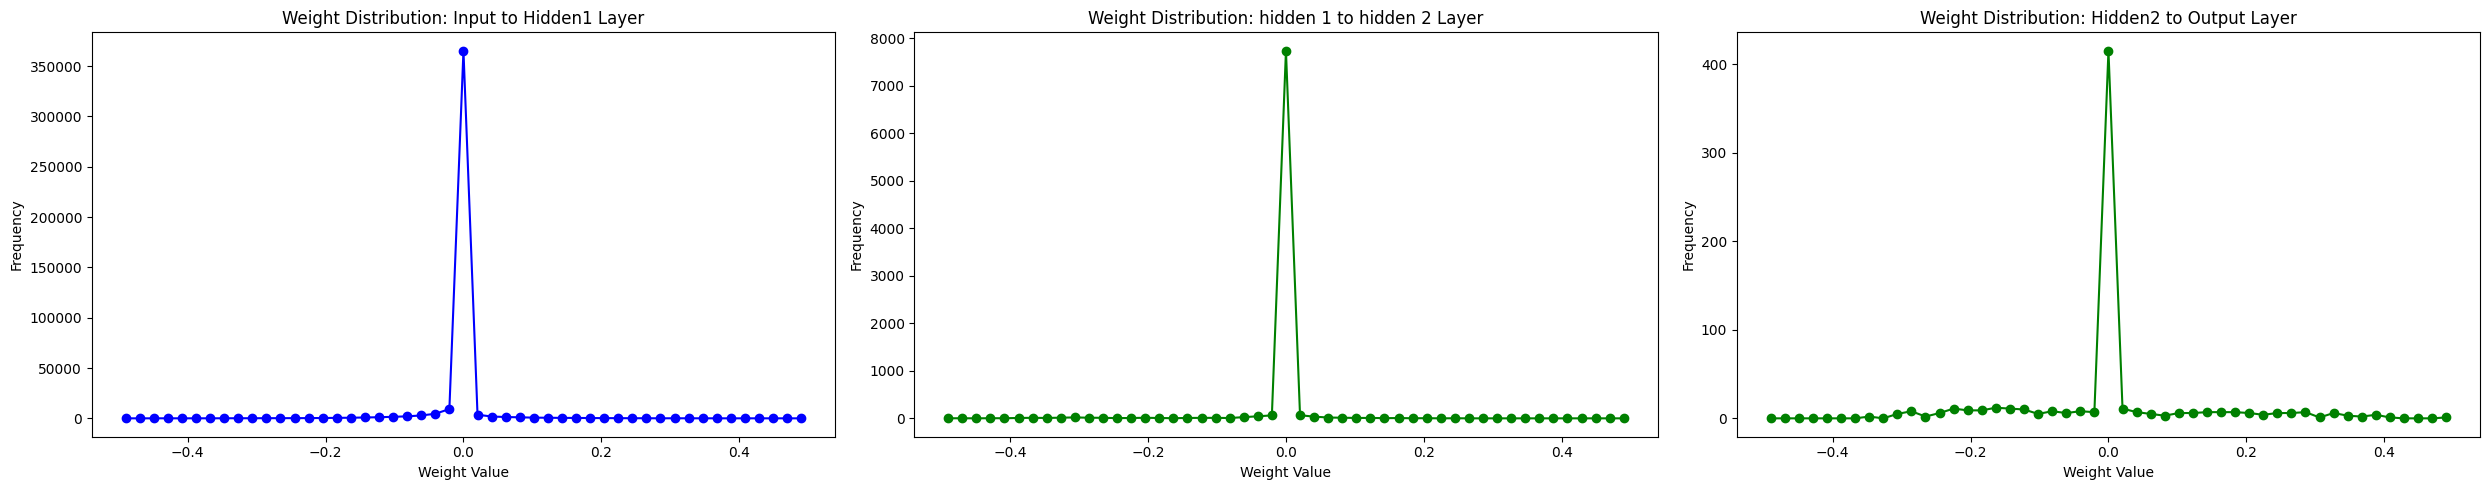

In [134]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [135]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 36358
Number of non-zero weights greater than 0.01 in layer 1: 457
Number of non-zero weights greater than 0.01 in layer 3: 226


In [136]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[2893853803.542538, 0.7743840688374725, 0.15327378251721147, 4363463979.188818, 0.23161942609205546, 0.47290345547186563, 36.44272420907972, 1071672895.9522369, 45837854.49765989, inf, 2.200902942338823, 0.48209915534595094, 0.5488350159784883, 12450.125903528096, 380300.58038768196, 0.3411031896151947, 2277649.8247639686, 30844391021.445393, 2.896793785265923, 670176960077380.1, 6.1593039640208056e+16, 704732.9358396642, 0.9964155072820429, 773593249.6231209, 12850223485.958473, 0.5503743903211428, 965465.4625200983, 5801.063825289424, 1.7168919285740556, 2.0128484291688947e+18, 0.6277540668348608, 0.6903948557062558, 7272879325.183849, 0.7642795694384322, inf, 8890947725268.023, 182176515.36431277, 3684015891687.89, 228.33798324266604, 203.9593523419635, 0.8502541910564336, 0.7829046129678939, 161391900641.01007, 0.5530325152690686, 1.5902231010236582e+16, 2.590008315236794, inf, 5.309785494110715e+19, inf, 2.4462543540121888e+17, 223.0723777773025, 12004082.171549613, 27546208454.18

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67757/2415192822.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67757/2415192822.py:5: RuntimeWarning: invalid value encountered in scalar divide
  norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))


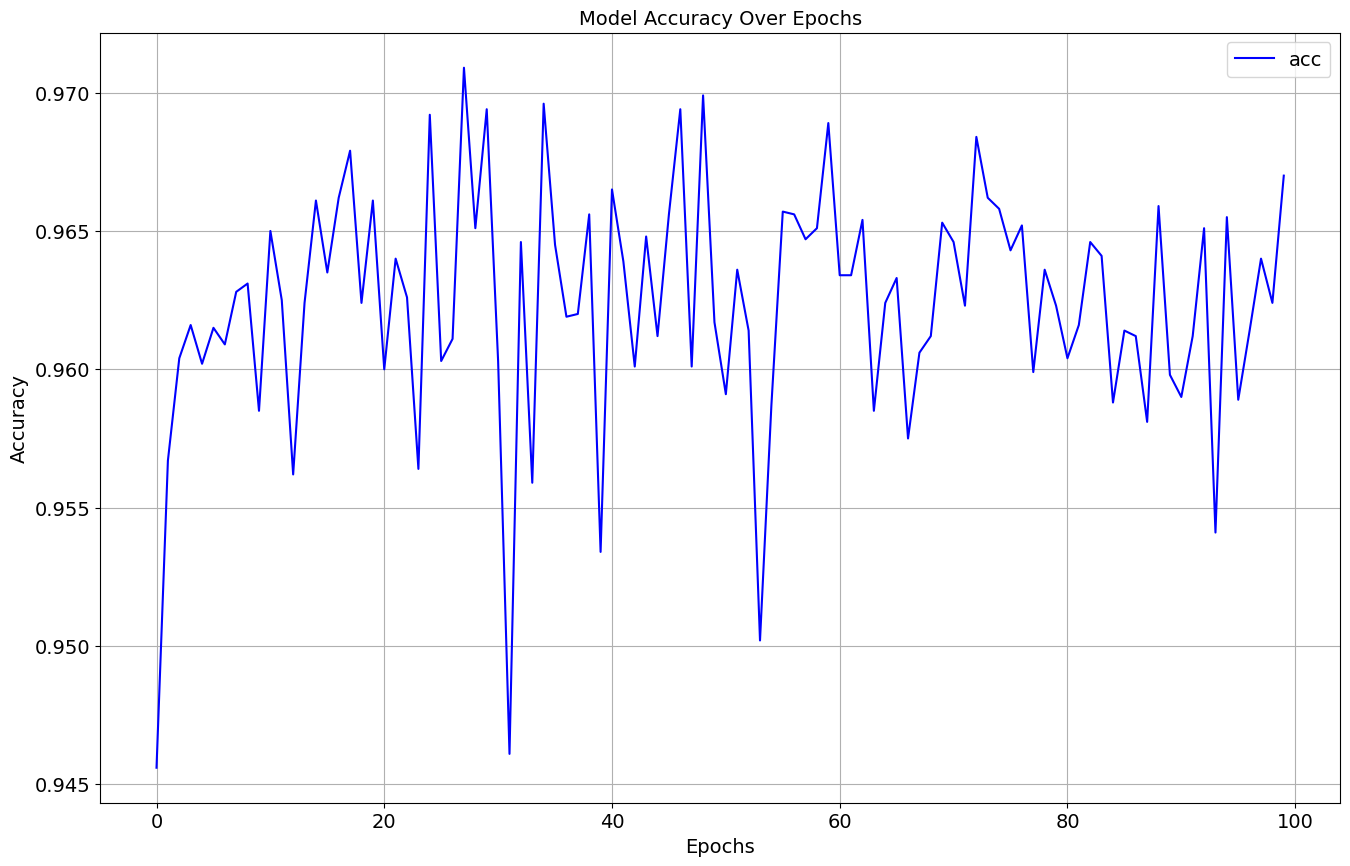

In [137]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [138]:
import pickle
with open('l2regularization0.pkl', 'wb') as f:
    pickle.dump(acc, f)

with open('l2regularizationTrainAcc0.pkl', 'wb') as f:
    pickle.dump(tacc, f)

torch.save(model.state_dict(), 'l2Model0.pt')